In [413]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data
import torchvision.transforms as transforms

# SciKit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# Python
import pandas as pd
import numpy as np
import time

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# utils
from utils import *

# Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [414]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [415]:
# ML Parameters
lr = 5e-4
min_lr = 1e-6
epochs = 800
batch_size = 512
clip_grad = 3
# Data Parameters
data_seq_len = [120, 20, 100, 70, 120] 
data_n_features = 1
data_embedding_dim = 64

In [416]:
#load train data
df_sensorA_normal = pd.read_csv('data/sensor_A_normal.csv')
df_sensorB_normal = pd.read_csv('data/sensor_B_normal.csv')
df_sensorC_normal = pd.read_csv('data/sensor_C_normal.csv')
df_sensorD_normal = pd.read_csv('data/sensor_D_normal.csv')
df_sensorE_normal = pd.read_csv('data/sensor_E_normal.csv')
print(len(df_sensorA_normal))
df_train = [df_sensorA_normal, df_sensorB_normal, df_sensorC_normal, df_sensorD_normal, df_sensorE_normal]

# load val data
df_sensorA_public = pd.read_csv('data/sensor_A_public.csv')
df_sensorB_public = pd.read_csv('data/sensor_B_public.csv')
df_sensorC_public = pd.read_csv('data/sensor_C_public.csv')
df_sensorD_public = pd.read_csv('data/sensor_D_public.csv')
df_sensorE_public = pd.read_csv('data/sensor_E_public.csv')
print(len(df_sensorA_public))
df_test = [df_sensorA_public, df_sensorB_public, df_sensorC_public, df_sensorD_public, df_sensorE_public]

# load test data
df_sensorA_private = pd.read_csv('data/sensor_A_private.csv')
df_sensorB_private = pd.read_csv('data/sensor_B_private.csv')
df_sensorC_private = pd.read_csv('data/sensor_C_private.csv')
df_sensorD_private = pd.read_csv('data/sensor_D_private.csv')
df_sensorE_private = pd.read_csv('data/sensor_E_private.csv')
print(len(df_sensorA_private))
df_private = [df_sensorA_private, df_sensorB_private, df_sensorC_private, df_sensorD_private, df_sensorE_private]

2875
4000
4000


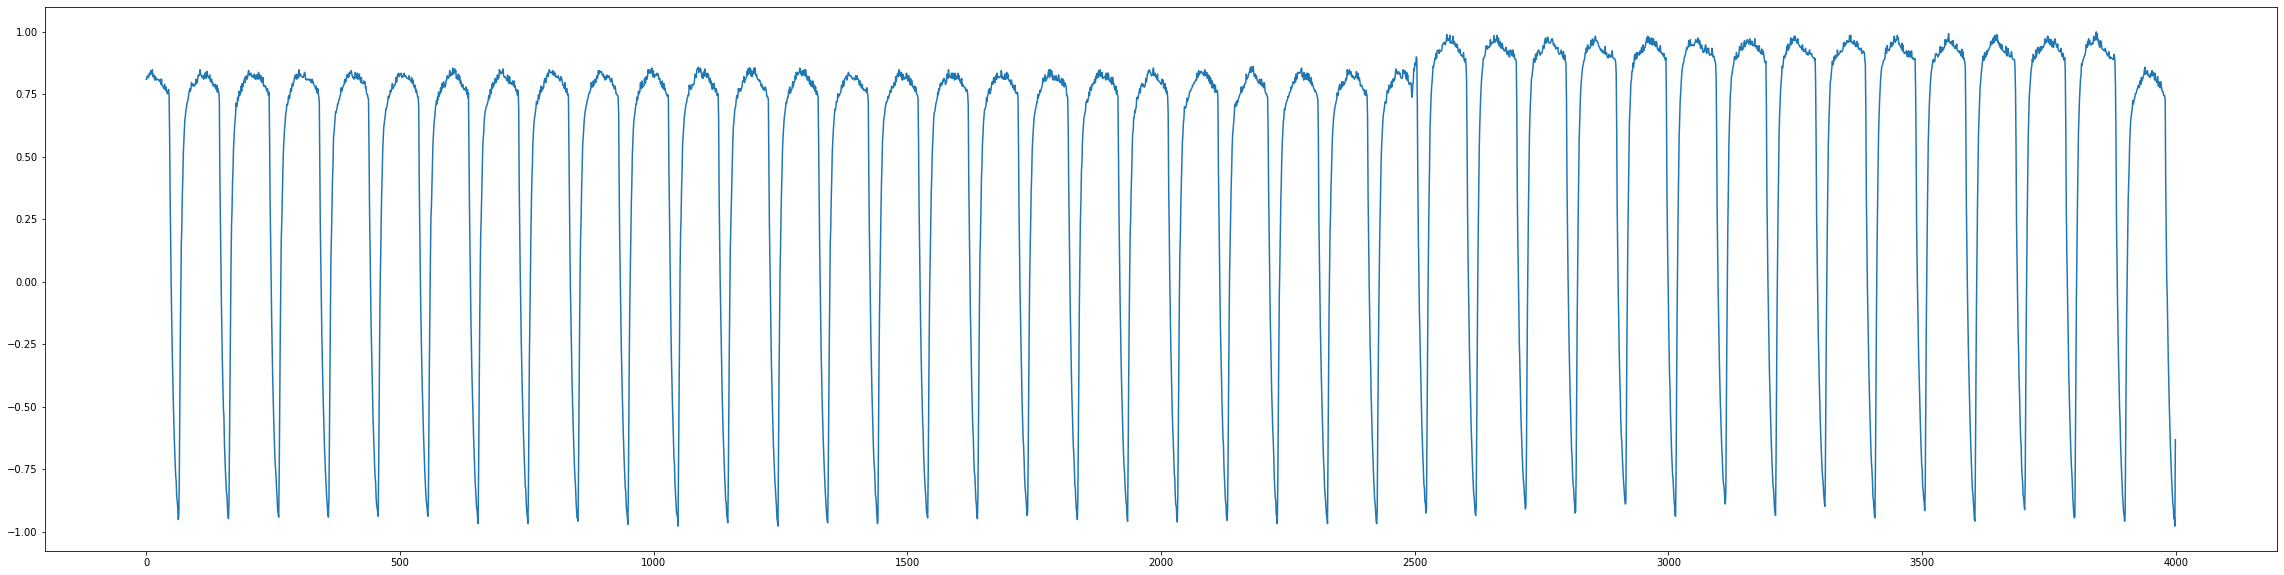

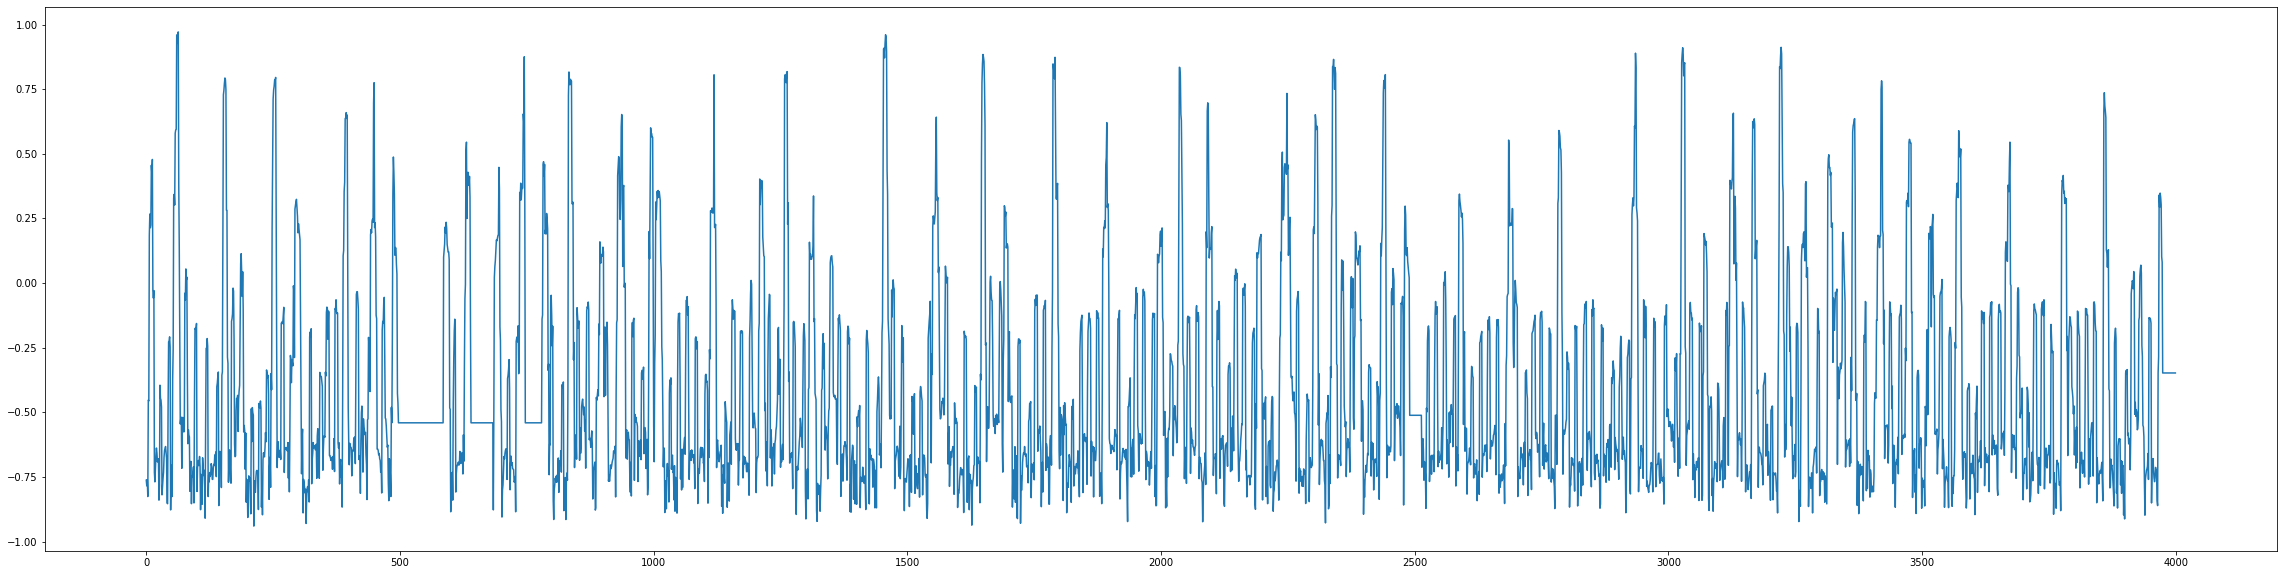

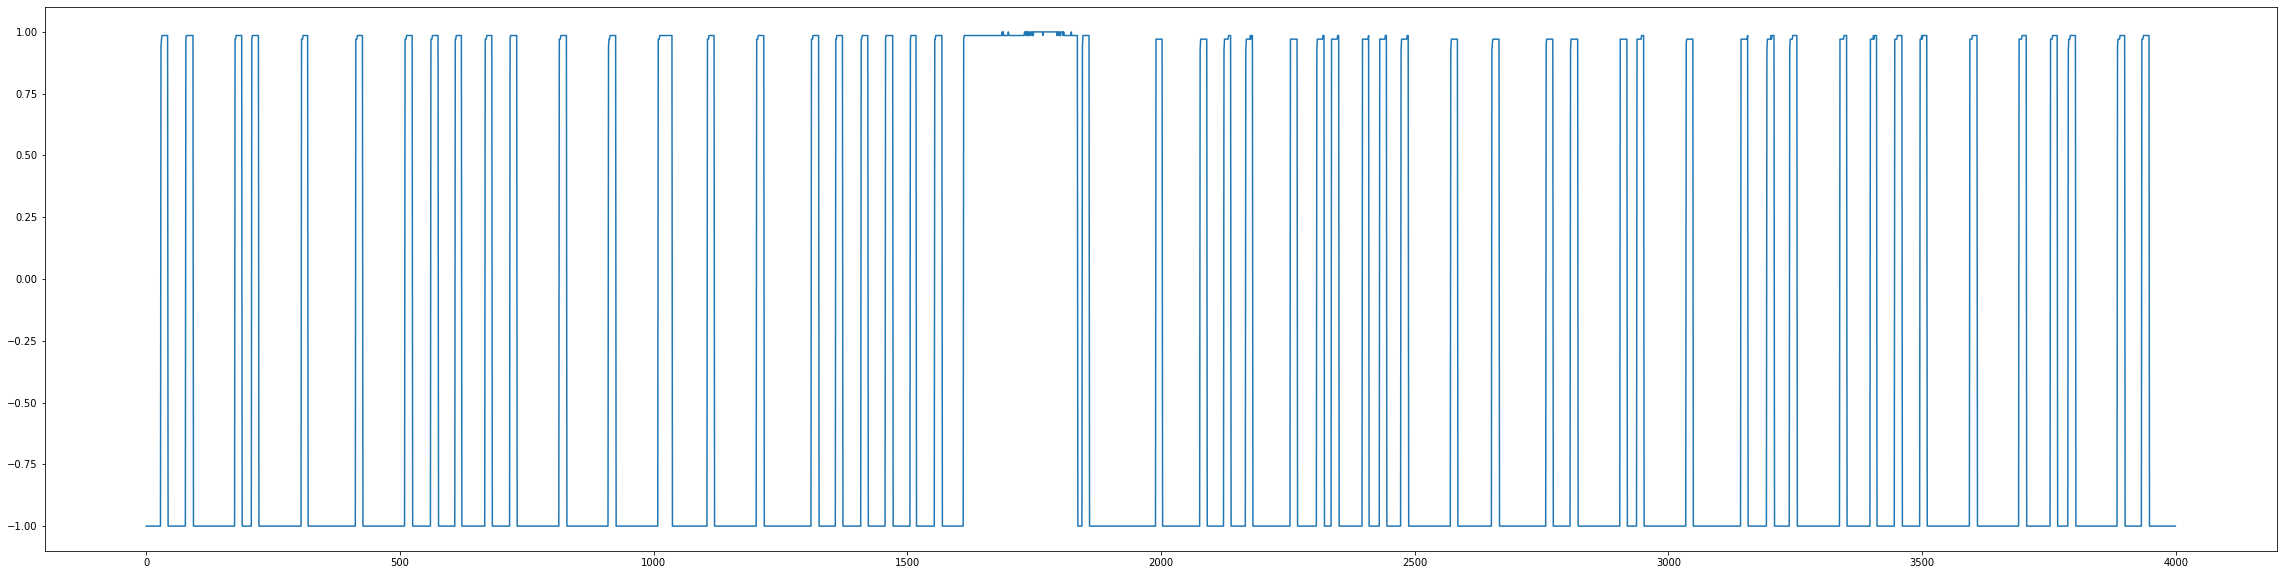

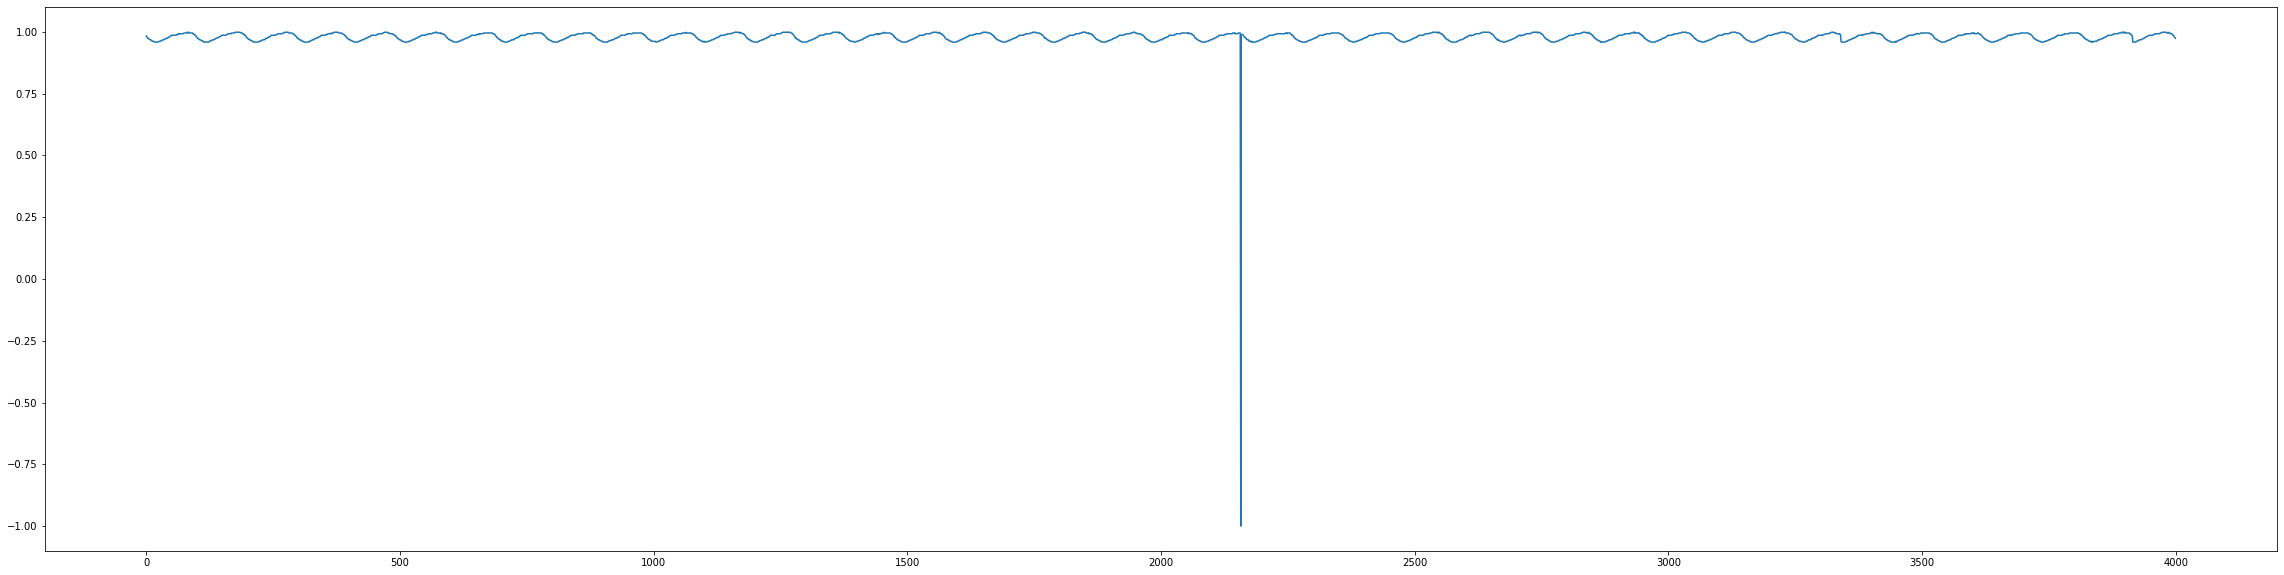

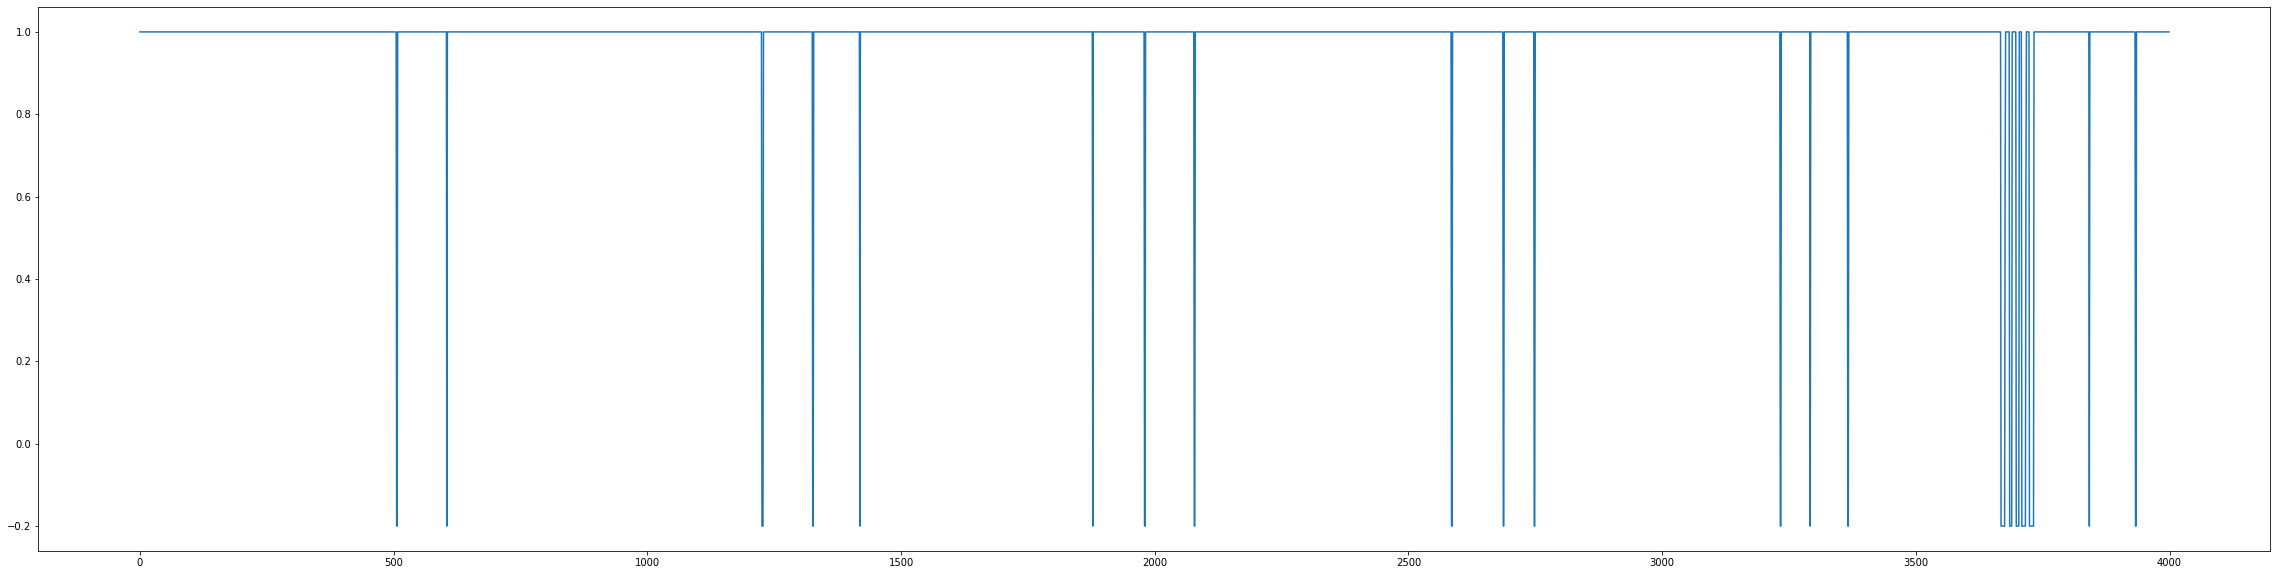

In [417]:
# plot
plt.figure(figsize=(40,10))
plt.plot(df_sensorA_public.index, df_sensorA_public.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorB_public.index, df_sensorB_public.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorC_public.index, df_sensorC_public.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorD_public.index, df_sensorD_public.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorE_public.index, df_sensorE_public.iloc[:, 0])
plt.show()

In [418]:
class SensorDataset(data.Dataset):
    """
        Support class for the loading and batching of sequences of samples

        Args:
            dataset (Tensor): Tensor containing all the samples
            sequence_length (int): length of the analyzed sequence by the LSTM
            transforms (object torchvision.transform): Pytorch's transforms used to process the data
    """
    ##  Constructor
    def __init__(self, df, seq_len=1, transform=None):
        self.dataset = df
        self.seq_len = seq_len
        self.transforms = transform

    ##  Override total dataset's length getter
    def __len__(self):
        return self.dataset.__len__()

    ##  Override single items' getter
    def __getitem__(self, idx):
        if idx+1 < self.seq_len:
            if self.transforms is not None:    
                item = torch.zeros(self.seq_len, self.dataset[0].__len__())
                item[self.seq_len-idx-1:] = self.transforms(self.dataset[:idx+1])
                return item, item
            else:
                item = []
                item[self.seq_len-idx-1:] = self.dataset[idx:self.seq_len]
                return item, item

        else:
            if self.transforms is not None:
                return self.transforms(self.dataset[idx-self.seq_len+1:idx+1]), self.transforms(self.dataset[idx-self.seq_len+1:idx+1])
            else:
                return self.dataset[idx-self.seq_len+1:idx+1], self.dataset[idx-self.seq_len+1:idx+1]

                
# Helper for transforming the data from a list to Tensor
def listToTensor(list):
    tensor = torch.empty(list.__len__(), list[0].__len__())
    for i in range(list.__len__()):
        tensor[i, :] = torch.from_numpy(list[i])
    return tensor 

# transform
data_transform = transforms.Lambda(lambda x: listToTensor(x))  

In [419]:

# Dataset Objects
train_dataset = []
for i, df in enumerate(df_train):
    data = np.array(df.iloc[:, 0].values).astype(float).reshape(-1, 1)
    train_dataset.append(SensorDataset(data, seq_len=data_seq_len[i], transform = data_transform))
val_dataset = []
for i, df in enumerate(df_test):
    data = np.array(df.iloc[:401, 0].values).astype(float).reshape(-1, 1)
    val_dataset.append(SensorDataset(data, seq_len=data_seq_len[i], transform = data_transform))
private_dataset = []
for i, df in enumerate(df_private):
    data = np.array(df.iloc[:, 0].values).astype(float).reshape(-1, 1)
    private_dataset.append(SensorDataset(data, seq_len=data_seq_len[i], transform = data_transform))

# Pytorch DataLoader objects
train_loader = []
for dataset in train_dataset:
    train_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))
val_loader = []
for dataset in val_dataset:
    val_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))
private_loader = []
for dataset in private_dataset:
    private_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))

In [420]:
class LSTMEncoder(nn.Module):
    
    def __init__(self, seq_len, n_features, embedding_dim):
        super(LSTMEncoder, self).__init__()
        
        # Parameters
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2*embedding_dim
        
        # Neural Network Layers
        self.lstm1 = nn.LSTM(self.n_features, self.hidden_dim, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_dim, self.embedding_dim, num_layers=1, batch_first=True)
    
    def forward(self, i): 
        i, _ = self.lstm1(i)               # from (batch, seq_len, n_features) to (batch, seq_len, hidden_dim)
        i, (hidden_n, _) = self.lstm2(i)   # from (batch, seq_len, hidden_dim) to (batch, seq_len, embedding_dim)
        return hidden_n                    # hidden_n shape: (num_layers*num_directions, batch, embedding_dim)


class LSTMDecoder(nn.Module):

    def __init__(self, seq_len, embedding_dim, n_features=1):
        super(LSTMDecoder, self).__init__()

        # Parameters
        self.seq_len = seq_len
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2*embedding_dim
        self.n_features = n_features
        
        # Neural Network Layers
        self.lstm1 = nn.LSTM(self.embedding_dim, self.embedding_dim, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(self.embedding_dim, self.hidden_dim, num_layers=1, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, i):
        # Do padding
        i = i.repeat(self.seq_len, 1, 1)                       # repeat (1, embedding_dim) to (seq_len, embedding_dim)
        i = i.reshape((-1, self.seq_len, self.embedding_dim))  # reshape to (batch, seq_len, embedding_dim)
        
        # Traverse neural layers
        i, _ = self.lstm1(i)      # from (batch, seq_len, embedding_dim) to (batch, seq_len, embedding_dim)
        i, _ = self.lstm2(i)      # from (batch, seq_len, embedding_dim) to (batch, seq_len, hidden_dim)
        i = self.output_layer(i)  # from (batch, seq_len, hidden_dim) to (batch, seq_len, n_features)
        
        return i


class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = LSTMEncoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = LSTMDecoder(seq_len, embedding_dim, n_features).to(device)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)    
    def forward(self, i):
        i = self.encoder(i)
        i = self.decoder(i)
        return i

In [421]:
def training(model, optimizer, trainset_iterator, validationset_iterator, epoch):
    # Define model1 for E1
    lr_schedule = cosine_scheduler(
        lr * batch_size / 256,
        min_lr,
        epochs, len(trainset_iterator),
        warmup_epochs=10,
    )
    train_losses, test_losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)

    for epoch in range(epoch):
        
        print("Epoch %d training started ..." % epoch)
        start_time = time.time()
        
        # Enter Train Mode
        model.train()     
        train_loss = 0
        for it, (ii, _) in enumerate(trainset_iterator):
            #print(ii)
            ii = ii.to(device)              # move to GPU if necessary
            it = len(trainset_iterator) * epoch + it  # global training iteration
            for i, param_group in enumerate(optimizer.param_groups):
                param_group["lr"] = lr_schedule[it]
            optimizer.zero_grad()           # generate prediction
            preds = model(ii)               # generate prediction
            loss = criterion(preds, ii)     # calculate loss
            loss.backward()                 # back propagation of gradients and update weights
            if clip_grad:
                param_norms = clip_gradients(model, clip_grad)
            optimizer.step()                # update optimizer
            train_loss += loss.item()       # record training losses

        # Enter Validation Mode
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for ii, _ in validationset_iterator:
                ii = ii.to(device)          # move to GPU if necessary
                preds = model(ii)           # generate prediction
                loss = criterion(preds, ii) # calculate loss
                test_loss += loss           # record validation testing losses
        
        end_time = time.time()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print("Epoch %d completed - train_loss: %f , test_loss: %f" % (epoch, train_loss, test_loss))
        print("Epoch %d training time: %f" %(epoch, (end_time - start_time)))
    
    return train_losses, test_losses

In [422]:
def predict(model, dataset_iterator, i):
    preds, losses = np.array([]), np.array([])
    criterion = nn.L1Loss(reduction='none').to(device)
    
    # Enter Validation Mode
    model = model.eval()
    with torch.no_grad():
        for ii, _ in dataset_iterator:
            # move to GPU if necessary
            ii = ii.to(device)
            
            # generate prediction
            pred = model(ii)
            
            # calculate loss
            loss = criterion(pred, ii)
            
            # record predictions
            preds = np.append(preds, pred[:, -1, :].cpu().numpy())
            
            # record mean loss of each sample
            loss = loss.reshape((-1, data_seq_len[i])).cpu().numpy()  # from (batch, seq_len, n_feature) to (batch, seq_len)
            losses = np.append(losses, [np.sum(i) for i in loss])  # sum of all seq_len losses into one loss
    
    preds = preds.reshape((-1, 1))  # reshape to (batch, seq_len)
    return preds, losses

In [423]:
for i in range(5):
    model = LSTMAutoencoder(data_seq_len[i], data_n_features, data_embedding_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Training:
    train_losses, test_losses = training(model, optimizer, train_loader[i], val_loader[i], epochs)

    # Saving trained models
    torch.save(model, f'./model/sensor_model_{i}.pth')

Epoch 0 training started ...
Epoch 0 completed - train_loss: 261707.046875 , test_loss: 27917.984375
Epoch 0 training time: 3.418456
Epoch 1 training started ...
Epoch 1 completed - train_loss: 257413.835938 , test_loss: 27253.878906
Epoch 1 training time: 3.402434
Epoch 2 training started ...
Epoch 2 completed - train_loss: 247563.687500 , test_loss: 26023.988281
Epoch 2 training time: 3.462713
Epoch 3 training started ...
Epoch 3 completed - train_loss: 229597.773438 , test_loss: 23800.640625
Epoch 3 training time: 3.432574
Epoch 4 training started ...
Epoch 4 completed - train_loss: 190911.785156 , test_loss: 19272.214844
Epoch 4 training time: 3.476469
Epoch 5 training started ...
Epoch 5 completed - train_loss: 222856.261719 , test_loss: 43317.289062
Epoch 5 training time: 3.439938
Epoch 6 training started ...
Epoch 6 completed - train_loss: 188785.816406 , test_loss: 19093.425781
Epoch 6 training time: 3.390022
Epoch 7 training started ...
Epoch 7 completed - train_loss: 139292.8

# Evaluate result on public

In [441]:
# load val data
df_sensorA_public = pd.read_csv('data/sensor_A_public.csv')
df_sensorB_public = pd.read_csv('data/sensor_B_public.csv')
df_sensorC_public = pd.read_csv('data/sensor_C_public.csv')
df_sensorD_public = pd.read_csv('data/sensor_D_public.csv')
df_sensorE_public = pd.read_csv('data/sensor_E_public.csv')
print(len(df_sensorA_public))
df_test = [df_sensorA_public, df_sensorB_public, df_sensorC_public, df_sensorD_public, df_sensorE_public]
target = []
for df in df_test:
    target.append(df.iloc[:, -1].values)
    df.drop(['label'], axis=1)


4000


In [442]:
val_dataset = []
for i, df in enumerate(df_test):
    data_test = np.array(df.iloc[:, 0].values).astype(float).reshape(-1, 1)
    val_dataset.append(SensorDataset(data_test, seq_len=data_seq_len[i], transform = data_transform))
val_loader = []
for dataset in val_dataset:
    val_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))
submission = np.array([])

In [443]:
for i in range(5):
    model = torch.load(f'./model/sensor_model_{i}.pth')
    reconstructed_val, losses_val = predict(model, val_loader[i], i)
    print(reconstructed_val.shape)
    origin_data = val_dataset[i].dataset
    print(origin_data)
    reconstructed_error = np.abs((reconstructed_val - origin_data))
    print("reconstructed_error:", reconstructed_error.shape)
    print("AUC score:", roc_auc_score(target[i], reconstructed_error))
    #submission = np.append(submission, reconstructed_error)
    submission = np.append(submission, target[i])

(4000, 1)
[[ 0.8107541 ]
 [ 0.8107541 ]
 [ 0.82448713]
 ...
 [-0.93774554]
 [-0.97707654]
 [-0.63149282]]
reconstructed_error: (4000, 1)
AUC score: 0.2935711639293582
(4000, 1)
[[-0.76209537]
 [-0.7839214 ]
 [-0.76064016]
 ...
 [-0.34739904]
 [-0.34739904]
 [-0.34739904]]
reconstructed_error: (4000, 1)
AUC score: 0.40666551758101055
(4000, 1)
[[-1.]
 [-1.]
 [-1.]
 ...
 [-1.]
 [-1.]
 [-1.]]
reconstructed_error: (4000, 1)
AUC score: 0.9129715849821987
(4000, 1)
[[0.98337001]
 [0.98030451]
 [0.97724004]
 ...
 [0.98030451]
 [0.97724004]
 [0.97417652]]
reconstructed_error: (4000, 1)
AUC score: 0.4025168391040725
(4000, 1)
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
reconstructed_error: (4000, 1)
AUC score: 0.6163871794871795


# Generate private result

In [444]:
# load private data
df_sensorA_private = pd.read_csv('data/sensor_A_private.csv')
df_sensorB_private = pd.read_csv('data/sensor_B_private.csv')
df_sensorC_private = pd.read_csv('data/sensor_C_private.csv')
df_sensorD_private = pd.read_csv('data/sensor_D_private.csv')
df_sensorE_private = pd.read_csv('data/sensor_E_private.csv')
print(len(df_sensorA_private))
df_private = [df_sensorA_private, df_sensorB_private, df_sensorC_private, df_sensorD_private, df_sensorE_private]

4000


In [445]:
private_dataset = []
for i, df in enumerate(df_private):
    data_private = np.array(df.iloc[:, 0].values).astype(float).reshape(-1, 1)
    private_dataset.append(SensorDataset(data_private, seq_len=data_seq_len[i], transform = data_transform))
private_loader = []
for dataset in private_dataset:
    private_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))

In [446]:
for i in range(5):
    model = torch.load(f'./model/sensor_model_{i}.pth')
    reconstructed_val, losses_val = predict(model, private_loader[i], i)
    print(reconstructed_val.shape)
    origin_data = private_dataset[i].dataset
    print(origin_data)
    reconstructed_error = np.abs((reconstructed_val - origin_data))
    print("reconstructed_error:", reconstructed_error.shape)
    #print("AUC score:", roc_auc_score(target[i], reconstructed_error))
    submission = np.append(submission, reconstructed_error)
print(submission.shape)


(4000, 1)
[[-0.38266008]
 [-0.15562042]
 [ 0.03574139]
 ...
 [ 0.3534098 ]
 [ 0.18749222]
 [ 0.04583956]]
reconstructed_error: (4000, 1)
(4000, 1)
[[-0.69516194]
 [-0.68570386]
 [-0.72571851]
 ...
 [-0.35030912]
 [-0.35030912]
 [-0.7977447 ]]
reconstructed_error: (4000, 1)
(4000, 1)
[[-1.]
 [-1.]
 [-1.]
 ...
 [-1.]
 [-1.]
 [-1.]]
reconstructed_error: (4000, 1)
(4000, 1)
[[0.97417652]
 [0.97111328]
 [0.97111328]
 ...
 [0.9956381 ]
 [0.9956381 ]
 [0.9956381 ]]
reconstructed_error: (4000, 1)
(4000, 1)
[[ 1. ]
 [ 1. ]
 [-0.2]
 ...
 [ 1. ]
 [ 1. ]
 [ 1. ]]
reconstructed_error: (4000, 1)
(40000,)


In [447]:
df_submission = pd.DataFrame(submission, columns=['pred'])
df_submission.insert(0, 'id', df_submission.index)
df_submission
df_submission.to_csv('submission.csv', index=False)